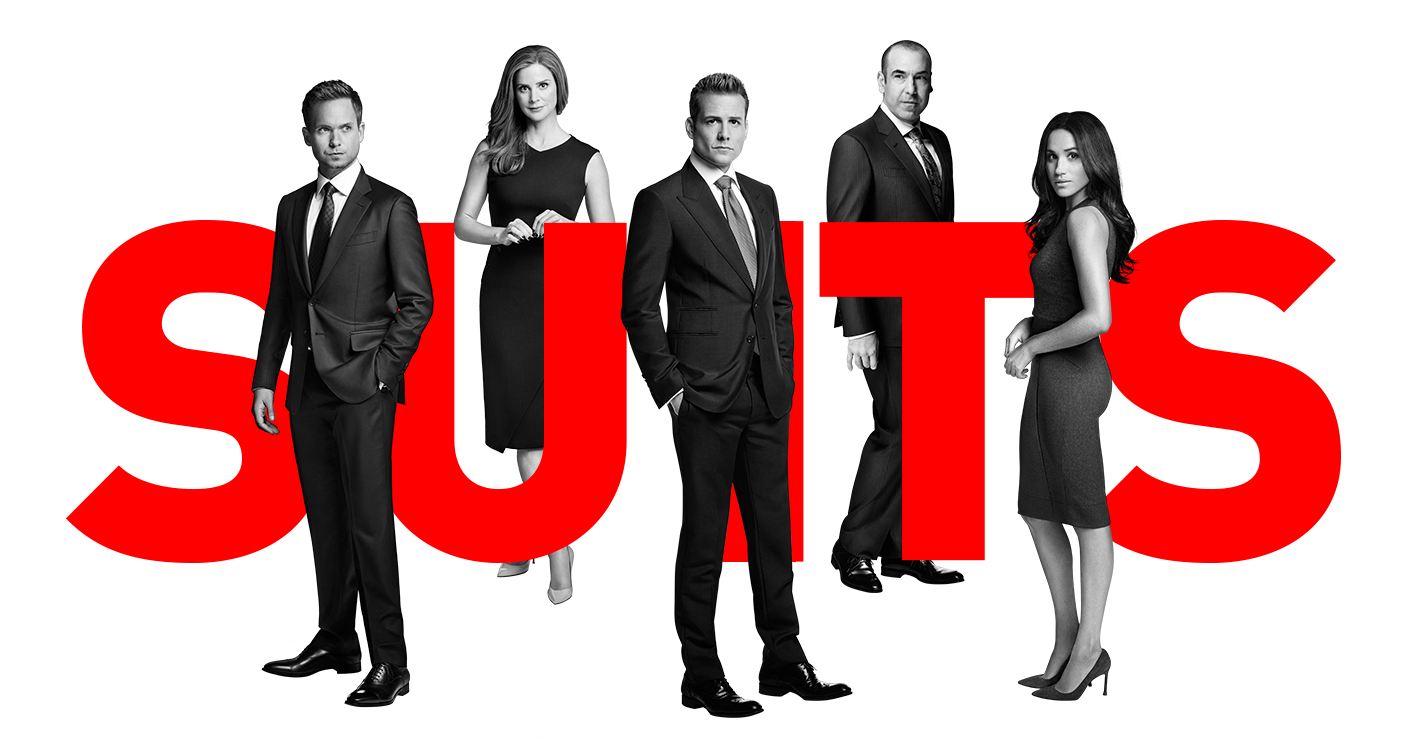

## The Language of Suits (TV)

*On the run from a drug deal gone bad, brilliant college dropout Mike Ross, finds himself working with Harvey Specter, one of New York City's best lawyers.* - [IMDB](https://www.imdb.com/title/tt1632701/)

Suits is an American legal drama television series that premiered on USA Network on 23rd June 2011. A series well known for it's quipy comebacks, this notebook is a quick look at the words, phrases and profanity of the scripts as they evolved over 9 seasons.

### Importing packages

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from better_profanity import profanity
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
%matplotlib inline

### Getting list of episodes

Many television series have been transcripted and are available online. Using the package 
[BeautifulSoup](https://pypi.org/project/beautifulsoup4/), these scripts can be scraped and parsed.
<br>
<br>
The first step was to create the list of URLs for each of the episode scripts, from the links available in the series index.

In [2]:
base_url = 'https://subslikescript.com'
suits_url = base_url + '/series/Suits-1632701'
suits_page = requests.get(suits_url)
suits_soup = BeautifulSoup(suits_page.content, 'html.parser')

ep_lst = []
for link in suits_soup.find_all('a'):
    if 'series/' in link.get('href'):
        ep_lst.append(base_url+link.get('href'))

In [3]:
ep_lst[:5]

['https://subslikescript.com/series/Suits-1632701/season-1/episode-1-Pilot',
 'https://subslikescript.com/series/Suits-1632701/season-1/episode-2-Errors_and_Omissions',
 'https://subslikescript.com/series/Suits-1632701/season-1/episode-3-Inside_Track',
 'https://subslikescript.com/series/Suits-1632701/season-1/episode-4-Dirty_Little_Secrets',
 'https://subslikescript.com/series/Suits-1632701/season-1/episode-5-Bail_Out']

### Getting episode scripts

Looping through the list of episode URLs, the HTML for each script was scraped. There were a few initial cleaning steps to remove some of the HTML remnants in the text, before storing each script in a DataFrame.

In [4]:
script_pattern = re.compile(r'<script[\s\S]*?</script>[\s\S]*?<script>[\s\S]*?</script>')
break_pattern = re.compile(r'<br/>{1,}')
div1_pattern = re.compile(r'^<div class="full-script">')
div2_pattern = re.compile(r'</div>$')

scripts = []

for ep in ep_lst:
    ep_page = requests.get(ep)
    ep_soup = BeautifulSoup(ep_page.content, 'html.parser')

    script = str(ep_soup.find("div", class_='full-script'))
    script = re.sub(script_pattern, '', script)
    script = re.sub(break_pattern, ' ', script)
    script = re.sub(div1_pattern, '', script)
    script = re.sub(div2_pattern, '', script)
    temp_lst = [script,ep.split('/')[-1],ep.split('/')[-2]]
    if temp_lst:
        scripts.append(temp_lst)

df_scripts = pd.DataFrame(scripts,columns=['script','episode','season'])  
df_scripts['episode_num'] = df_scripts['episode'].str.extract('^episode-(\d+)').astype('int')
df_scripts.head(5)

,script,episode,season,episode_num
0,(ALL TALKING INDISTINCTLY) Gerald Tate's here...,episode-1-Pilot,season-1,1
1,"Uh... What is that, three in a row? That wou...",episode-2-Errors_and_Omissions,season-1,2
2,♪ It's a perfect day ♪ ♪ To go and tie one on...,episode-3-Inside_Track,season-1,3
3,"Harvard trivia, the lightning round. [Snaps] ...",episode-4-Dirty_Little_Secrets,season-1,4
4,Ross. Triple double. Courtesy of America's fav...,episode-5-Bail_Out,season-1,5


### Cleaning the scripts

Before doing any analysis, a quick clean of the script values was done. The scripts were changed to lowercase, and stripped of some unnecessary symbols and other false text.
<br><br>
Some parts of the scripts have character names followed by a colon which were removed, along with scene-setting text contained in round or square brackets. Some additional metadata by the transcript author was present in the scripts surrounded by equal signs.
<br><br>
Finally, lyrics from the iconic theme tune *Greenback Boogie* by Ima Robot features in some of the scripts, so this is removed.

In [5]:
def clean_script(s):
    s = s.lower()
    s = re.sub(r'[,\./\?!"-]', '', s)
    s = re.sub(r'\n', ' ', s)
    s = re.sub(r'\(.*?\)|\[.*?\]', ' ', s)   # Scene-setting text in brackets
    s = re.sub(r'\w+\:', '', s)              # Character names
    s = re.sub(r'--', ' ', s)
    s = re.sub(r'==.*?==',' ', s, flags=re.IGNORECASE)
    s = re.sub(r'See the money.*?boogie', ' ', s, flags=re.IGNORECASE) # Theme song
    s = re.sub(r'\s+', ' ', s)
    return s

df_scripts['clean_script'] = df_scripts['script'].apply(clean_script)

### Script Uniqueness

Taking the count of total words and count of unique words used in the script, a metric of each scripts "uniqueness" can be calculated and plotted on a [Seaborn heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html). 

In [6]:
df_scripts['n_unique_words'] = df_scripts['clean_script'].str.replace('\'s','', regex=True).apply(lambda x: len(set(x.split(' '))))
df_scripts['n_total_words'] = df_scripts['clean_script'].str.replace('\'s','', regex=True).apply(lambda x: len(x.split(' ')))
df_scripts['unique_word_ratio'] = df_scripts['n_unique_words'] / df_scripts['n_total_words']

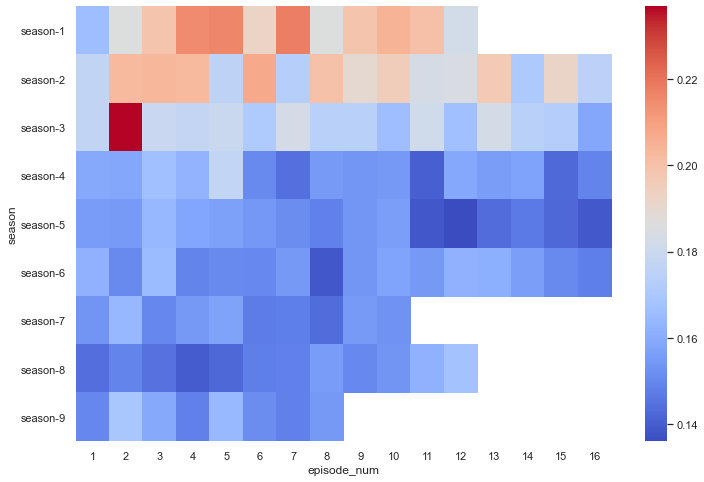

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df_scripts.pivot('season','episode_num','unique_word_ratio'), cmap='coolwarm')
plt.yticks(rotation=0)
plt.show()

### "What the h\*ll do you think you're doing?" - The swears of Suits

With the quips comes its fair share of swears. Using the [better_profanity](https://pypi.org/project/better-profanity/) package, a function was created to count the number of words classified as profanity by the package within each script.

In [8]:
def count_profanity(s):
    words = s.split(' ')
    prof_count = 0
    for word in words:
        if profanity.contains_profanity(word):
            prof_count += 1         
    return prof_count
        
df_scripts['count_profanity'] = df_scripts['clean_script'].apply(count_profanity)

The ratio of number of profanity classified words to total words in the script was found and visualized once more on a Seaborn heatmap.

In [9]:
df_scripts['profanity_word_ratio'] = df_scripts['count_profanity'] / df_scripts['n_total_words']

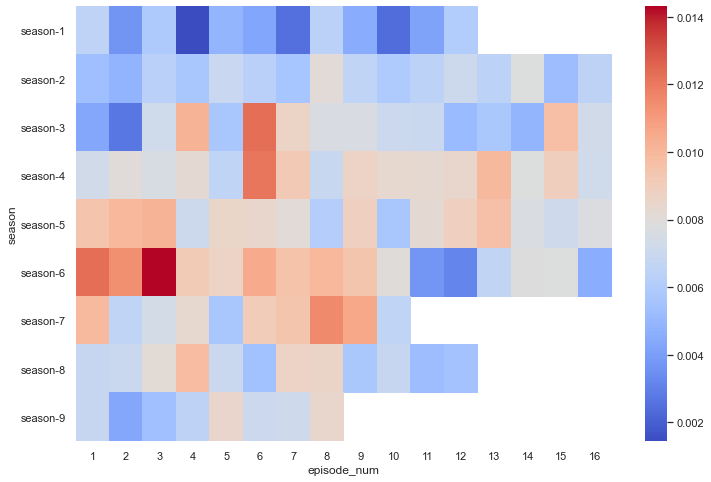

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(df_scripts.pivot('season','episode_num','profanity_word_ratio'), cmap='coolwarm')
plt.yticks(rotation=0)
plt.show()

To explore the specific profanity used within each script, another function was created to extract any words positively classified by the better_profanity function into a list.

In [11]:
def list_profanity(s):
    words = s.split(' ')
    prof_list = []
    for word in words:
        if profanity.contains_profanity(word):
            prof_list.append(word)
             
    return prof_list

df_scripts['prof_list'] = df_scripts['clean_script'].apply(list_profanity)

The list of profanity for each script was then unpacked into a new DataFrame to calculate the count of each per episode, with the words censored for display.

In [12]:
df_prof_list = pd.DataFrame(columns=['word','count','season','episode_num','series_episode_num'])

for idx, row in df_scripts.iterrows():
    df_temp = pd.DataFrame.from_dict(Counter(row['prof_list']), orient='index').reset_index()
    df_temp = df_temp.rename(columns={'index':'word', 0:'count'})
    df_temp['season'] = row['season']
    df_temp['episode_num'] = row['episode_num']
    df_temp['series_episode_num'] = idx+1
    df_prof_list = df_prof_list.append(df_temp)

df_prof_list['count'] = df_prof_list['count'].astype(int)
df_prof_list['series_episode_num'] = df_prof_list['series_episode_num'].astype(float)
df_prof_list['clean_word'] = df_prof_list['word'].str.replace('[aeiou]','*',regex=True, n=1)

In [13]:
print('Top 20 profanity words of the show:')
df_prof_list[['clean_word','count']].groupby(by='clean_word').sum().nlargest(20,'count')

Top 20 profanity words of the show:


,count
clean_word,
h*ll,1100
sh*t,1097
b*llshit,623
g*ddamn,516
g*d,470
d*mn,371
*ss,357
b*tch,197
*sshole,138


To show how the usage of the top 10 words from this list evolved over the series, a [Seaborn Ridge plot](https://seaborn.pydata.org/examples/kde_ridgeplot.html) was created below.
<br><br>
First the profanity word list needed to be transformed for use in a density based visualisation. The profanity list DataFrame was first filtered for the top 10 words, then the words were duplicated to create N rows based on the count in each episode using the [Index.repeat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.repeat.html) pandas function.

In [14]:
df_prof_list_top_ten = df_prof_list[df_prof_list['word'].isin(df_prof_list[['word','count']].groupby(by='word').sum().nlargest(10,'count').index)]
df_prof_list_top_ten_split = df_prof_list_top_ten.loc[df_prof_list_top_ten.index.repeat(df_prof_list_top_ten['count'])].reset_index(drop=True)

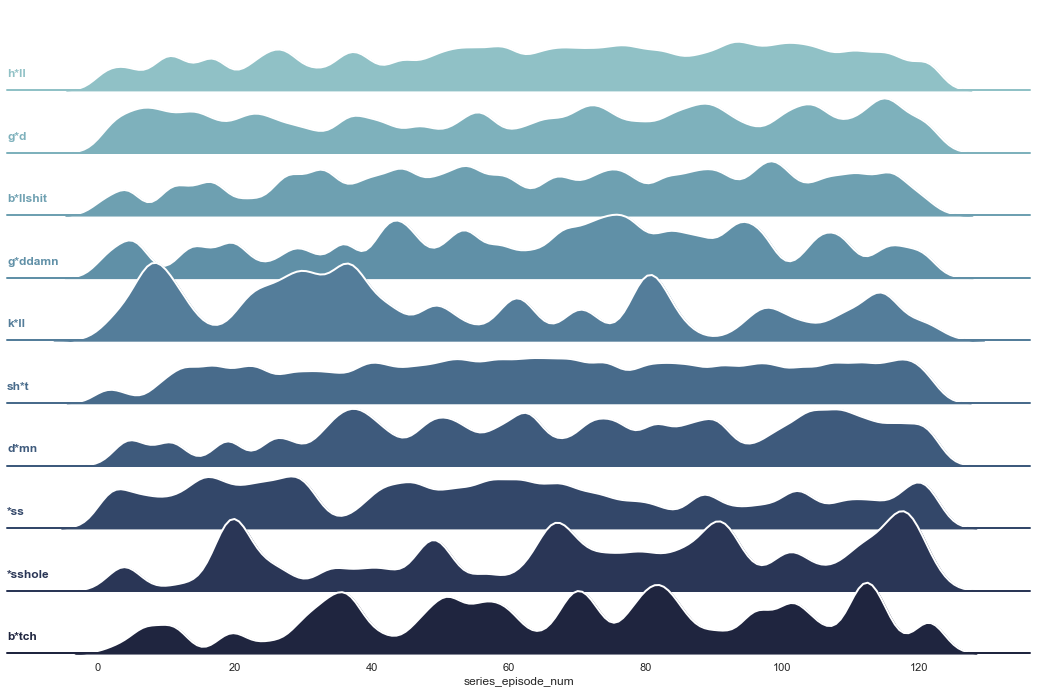

In [15]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(len(df_prof_list_top_ten_split['clean_word'].unique()), rot=-.25, light=.7)
g = sns.FacetGrid(df_prof_list_top_ten_split, row='clean_word', hue='clean_word', aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'series_episode_num',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'series_episode_num', clip_on=False, color='w', lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'series_episode_num')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

### Top n-grams of the series

Using the [ngrams](https://www.kite.com/python/docs/nltk.ngrams) function of the [Natural Language Toolkit](https://www.nltk.org/), commonly used word combinations throughout the series can be explored similarly to the top profanity.

In [16]:
full_series = ' '.join(df_scripts['clean_script'].values.tolist())

In [17]:
# Censoring the profanity in the scripts
for idx, row in df_prof_list[['word','clean_word']].drop_duplicates().iterrows():
    full_series = full_series.replace(row['word'],row['clean_word'])

In [18]:
from nltk import ngrams

In [19]:
print('Top 4-grams:')
Counter(ngrams(full_series.split(), 4)).most_common(20)

Top 4-grams:


[(('are', 'you', 'talking', 'about'), 381),
 (('what', 'are', 'you', 'doing'), 306),
 (('what', 'are', 'you', 'talking'), 297),
 (('in', 'the', 'first', 'place'), 280),
 (('are', 'you', 'doing', 'here'), 249),
 (('i', "don't", 'want', 'to'), 244),
 (('you', 'want', 'me', 'to'), 242),
 (('what', 'do', 'you', 'mean'), 230),
 (('i', 'need', 'you', 'to'), 230),
 (('i', 'want', 'you', 'to'), 194),
 (("don't", 'give', 'a', 'sh*t'), 186),
 (('son', 'of', 'a', 'b*tch'), 184),
 (('i', "don't", 'give', 'a'), 170),
 (('what', 'do', 'you', 'want'), 161),
 (("i'm", 'not', 'going', 'to'), 159),
 (('i', "don't", 'know', 'what'), 159),
 (('the', 'h*ll', 'are', 'you'), 145),
 (('nothing', 'to', 'do', 'with'), 140),
 (('i', "don't", 'care', 'what'), 130),
 (('what', 'the', 'h*ll', 'are'), 127)]

In [20]:
print('Top 5-grams:')
Counter(ngrams(full_series.split(), 5)).most_common(20)

Top 5-grams:


[(('what', 'are', 'you', 'talking', 'about'), 291),
 (('what', 'are', 'you', 'doing', 'here'), 234),
 (('i', "don't", 'give', 'a', 'sh*t'), 165),
 (('what', 'the', 'h*ll', 'are', 'you'), 117),
 (('what', 'can', 'i', 'do', 'for'), 90),
 (('can', 'i', 'do', 'for', 'you'), 90),
 (('has', 'nothing', 'to', 'do', 'with'), 77),
 (('the', 'h*ll', 'are', 'you', 'talking'), 75),
 (('h*ll', 'are', 'you', 'talking', 'about'), 75),
 (('are', 'you', 'doing', 'here', 'i'), 69),
 (('figure', 'out', 'a', 'way', 'to'), 64),
 (('you', 'wanted', 'to', 'see', 'me'), 62),
 (('you', 'son', 'of', 'a', 'b*tch'), 59),
 (('i', 'need', 'to', 'talk', 'to'), 58),
 (('do', 'you', 'want', 'me', 'to'), 57),
 (('are', 'you', 'talking', 'about', 'i'), 57),
 (("don't", 'give', 'a', 'sh*t', 'about'), 51),
 (("i'm", 'here', 'to', 'tell', 'you'), 51),
 (('you', 'think', 'i', "don't", 'know'), 50),
 (('no', 'no', 'no', 'no', 'no'), 49)]